# Evaluation of 2 Models

In [1]:
model_1 = "pix2pix_1_0_input_base_2"
model_1_type = "pix2pix"
model_2 = "pix2pix_wgangp_1_0_input_base_2"
model_2_type = "pix2pix"

data_1 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_1_type = "noise"
data_2 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_2_type = "noise"
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined

different_naming_1 = True
different_naming_2 = True

batch_size = 1
data_to_process_size = "inf"
image_size = 256

### Env Setup

In [2]:
!conda create -n eval python=3.8 -y
!conda activate eval

Retrieving notices: ...working... done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/tippolit/anaconda3/envs/eval

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2025.2.25-h06a4308_0 
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.40-h12ee557_0 
  libffi             pkgs/main/linux-64::libffi-3.4.4-h6a678d5_1 
  libgcc-ng          pkgs/main/linux-64::libgcc-ng-11.2.0-h1234567_1 
  libgomp            pkgs/main/linux-64::libgomp-11.2.0-h1234567_1 
  libstdcxx-ng       pkgs/main/linux-64::libstdcxx-ng-11.2.0-h1234567_1 
  ncurses            pkgs/main/linux-64::ncurses-6.4-h6a678d5_0 
  openssl            pkgs/main/linux-64::openssl-3.0.16-h5eee18b_0 
  pip                pkgs/m

Activate now eval env and run:

In [ ]:
!pip install pandas
!pip install ipython
!pip install ipykernel
!pip install opencv-python
!pip install shapely
!pip install pytorch-msssim
!pip install scikit-image
!pip install -r requirements.txt

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached backcall-0.2.

> Set 'eval' as your python env

### Imports

In [2]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [3]:
!python --version

Python 3.8.20


### Helper

In [4]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False, log=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    # print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    # print(f"Transformed shape to: {img_shape}")

    # get better look at reflections
    # mask = (img >= 200) & (img <= 240)
    # img[mask] -= 33
    # img = cv2.add(img, np.full(img.shape, 33, dtype=img.dtype))

    # Better distribution
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = normalized_img * (255)
    #img = cv2.equalizeHist(img)

    # invert images
    if invert:
        # print("Invert images...")
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    if log:
        img[img <= 0] = 1e-3
        # img = np.apply_along_axis(np.log, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        # print(f"Using '{plt_style}' plotting style.")

    # plotting
    # print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2] == 3:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            # print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        if log:
            cur_ax.imshow(cur_img, cmap=used_cmap, norm=LogNorm())
        else:
            cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False, log=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    elif color_space.lower() in ["grey", "gray", "g"]:
        images = np.array([cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths])
        images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert, log=log)
    return images

### Run Tests

In [5]:
command = (
  f"python test.py "
  f"--dataroot {data_1} "
  f"--name {model_1} "
  f"--model {model_1_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_1_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_1} "
  f"--phase test "
  f"--eval"
)

if different_naming_1:
  command += " --different_building_naming"

if data_1_type == "physgen":
  command += f" --variation {physgen_variation}"

# Finally run it
!{command}

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: True                          	[default: False]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[

In [6]:
command = (
  f"python test.py "
  f"--dataroot {data_2} "
  f"--name {model_2} "
  f"--model {model_2_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_2_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_2} "
  f"--phase test "
  f"--eval"
)

if different_naming_2:
  command += " --different_building_naming"

if data_2_type == "physgen":
  command += f" --variation {physgen_variation}"

# Run it
!{command}


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: True                          	[default: False]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/pix2pix_wgangp_1_0_input_base_2/latest_net_G.pth
/home/tippolit/src/paired_image-to-image_translation/models/base_model.py:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

### Extract Test Predictions

In [7]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [8]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/pred/888_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/348_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base_2/osm/348_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/519_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base_2/osm/519_LAEQ.png'
[info] copied real from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/pred/855_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base

In [9]:
evaluation_path = f"./eval/{model_2}/{model_2}/test_latest/images"
target_path = f"../../data/eval/{model_2}"

In [10]:
!python eval_extractor.py \
    --name {model_2} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/pred/888_LAEQ.png'
[info] copied osm from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/348_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/osm/348_LAEQ.png'
[info] copied osm from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/519_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/osm/519_LAEQ.png'
[info] copied real from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/

### Calc Eval metrics

In [11]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples:  14%|██▊                 | 141/1000 [00:03<00:18, 47.54it/s]

Evaluating samples: 100%|███████████████████| 1000/1000 [00:21<00:00, 46.45it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      0.657134     3.693332  ...     3.693309     5.193099
std       1.167637     4.976422  ...     4.976252    19.222919
min       0.092247     0.456824  ...     0.456831     0.000000
25%       0.237406     1.604251  ...     1.604262     0.869560
50%       0.328611     2.316456  ...     2.316478     0.900905
75%       0.551463     3.678601  ...     3.678654     1.785713
max      11.151428    55.063236  ...    55.062553   100.000000

[8 rows x 6 columns]


In [12]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_2}/real \
    --pred_dir ../../data/eval/{model_2}/pred \
    --osm_dir ../../data/eval/{model_2}/osm \
    --output ./eval_results/evaluation_{model_2}.csv

Evaluating samples:  13%|██▌                 | 131/1000 [00:03<00:18, 47.57it/s]

Evaluating samples: 100%|███████████████████| 1000/1000 [00:21<00:00, 46.83it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      0.354686     2.281928  ...     2.281959     0.221651
std       0.285495     1.743407  ...     1.743434     0.382935
min       0.034551     0.169442  ...     0.169432     0.000000
25%       0.152209     1.009954  ...     1.009970     0.000000
50%       0.256961     1.688638  ...     1.688663     0.000000
75%       0.500349     3.165770  ...     3.165818     0.806447
max       2.228812    12.572872  ...    12.573064     1.612902

[8 rows x 6 columns]


### Show Results

In [13]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

mae_model_2_name = f'MAE_{model_2}'
los_mae_model_2_name = f'LoS_MAE_{model_2}'
nlos_mae_model_2_name = f'NLoS_MAE_{model_2}'
mape_model_2_name = f'MAPE_{model_2}'
los_wmape_model_2_name = f'LoS_wMAPE_{model_2}'
nlos_wmape_model_2_name = f'NLoS_wMAPE_{model_2}'

In [14]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
df_1

Nan found in sample ids: 0


sample_id  MAE_pix2pix_1_0_input_base_2  MAPE_pix2pix_1_0_input_base_2  \
0          707                      0.419808                       3.141902   
1          283                      0.532891                       3.398218   
2          584                      0.866472                       5.958340   
3          967                      0.579642                       3.171944   
4          132                      0.707098                       4.975389   
..         ...                           ...                            ...   
995         92                      0.302154                       1.918879   
996        435                      6.277878                      29.716572   
997        197                      0.721878                       4.548018   
998        689                      0.231754                       1.469430   
999        856                      0.668066                       4.544942   

     LoS_MAE_pix2pix_1_0_input_base_2  NLoS_MAE_pix2pix_1_0_input_base_2  \
0                            0.419809                           0.392155   
1                            0.532893                           0.392159   
2                            0.866473                           0.784313   
3                            0.579651                           0.000000   
4                            0.707103                           0.392159   
..                                ...                                ...   
995                          0.302147                           0.784313   
996                          6.277364                          39.999996   
997                          0.721884                           0.392155   
998                          0.231752                           0.392155   
999                          0.668070                           0.392155   

     LoS_wMAPE_pix2pix_1_0_input_base_2  NLoS_wMAPE_pix2pix_1_0_input_base_2  
0                              3.141936                             0.943391  
1                              3.398257                             0.854704  
2                              5.958401                             1.960783  
3                              3.171992                             0.000000  
4                              4.975450                             0.925930  
..                                  ...                                  ...  
995                            1.918880                             1.851851  
996                           29.715500                           100.000000  
997                            4.548073                             0.925921  
998                            1.469440                             0.854696  
999                            4.544997                             0.943391  

[1000 rows x 7 columns]

In [15]:
df_2 = pd.read_csv(f"./eval_results/evaluation_{model_2}.csv")
# df_2 = df_2.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_2 = df_2.rename(columns={'MAE': mae_model_2_name, 
                            'LoS_MAE': los_mae_model_2_name,
                            'NLoS_MAE': nlos_mae_model_2_name,
                            'MAPE':mape_model_2_name,
                            'LoS_wMAPE': los_wmape_model_2_name,
                            'NLoS_wMAPE': nlos_wmape_model_2_name
                            }
                   )
# extract sample_ids
sample_id_series = df_2["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_2["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_2["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_2["sample_id"].isna().sum())
df_2 = df_2.dropna(subset=["sample_id"])
df_2["sample_id"] = df_2["sample_id"].astype(int)
df_2

Nan found in sample ids: 0


sample_id  MAE_pix2pix_wgangp_1_0_input_base_2  \
0          707                             0.361148   
1          283                             0.468876   
2          584                             0.821671   
3          967                             1.118320   
4          132                             0.663925   
..         ...                                  ...   
995         92                             0.198059   
996        435                             0.610298   
997        197                             0.565275   
998        689                             0.103646   
999        856                             0.651754   

     MAPE_pix2pix_wgangp_1_0_input_base_2  \
0                                2.296215   
1                                2.692772   
2                                5.469751   
3                                8.529253   
4                                5.176155   
..                                    ...   
995                              1.184288   
996                              4.165039   
997                              3.495300   
998                              0.725976   
999                              4.318361   

     LoS_MAE_pix2pix_wgangp_1_0_input_base_2  \
0                                   0.361154   
1                                   0.468883   
2                                   0.821683   
3                                   1.118331   
4                                   0.663935   
..                                       ...   
995                                 0.198062   
996                                 0.610301   
997                                 0.565284   
998                                 0.103642   
999                                 0.651764   

     NLoS_MAE_pix2pix_wgangp_1_0_input_base_2  \
0                                    0.000000   
1                                    0.000000   
2                                    0.000000   
3                                    0.392159   
4                                    0.000000   
..                                        ...   
995                                  0.000000   
996                                  0.392159   
997                                  0.000000   
998                                  0.392155   
999                                  0.000000   

     LoS_wMAPE_pix2pix_wgangp_1_0_input_base_2  \
0                                     2.296250   
1                                     2.692813   
2                                     5.469835   
3                                     8.529369   
4                                     5.176234   
..                                         ...   
995                                   1.184306   
996                                   4.165088   
997                                   3.495353   
998                                   0.725974   
999                                   4.318427   

     NLoS_wMAPE_pix2pix_wgangp_1_0_input_base_2  
0                                      0.000000  
1                                      0.000000  
2                                      0.000000  
3                                      0.840340  
4                                      0.000000  
..                                          ...  
995                                    0.000000  
996                                    0.980396  
997                                    0.000000  
998                                    0.854696  
999                                    0.000000  

[1000 rows x 7 columns]

In [16]:
merged_df = pd.merge(df_1, df_2, on='sample_id', how='outer')
print(f"Value Counts:\n{merged_df.value_counts()}")
print(f"\n\nNulls:\n{merged_df.isna().sum()}\n\n")
merged_df

Value Counts:
sample_id  MAE_pix2pix_1_0_input_base_2  MAPE_pix2pix_1_0_input_base_2  LoS_MAE_pix2pix_1_0_input_base_2  NLoS_MAE_pix2pix_1_0_input_base_2  LoS_wMAPE_pix2pix_1_0_input_base_2  NLoS_wMAPE_pix2pix_1_0_input_base_2  MAE_pix2pix_wgangp_1_0_input_base_2  MAPE_pix2pix_wgangp_1_0_input_base_2  LoS_MAE_pix2pix_wgangp_1_0_input_base_2  NLoS_MAE_pix2pix_wgangp_1_0_input_base_2  LoS_wMAPE_pix2pix_wgangp_1_0_input_base_2  NLoS_wMAPE_pix2pix_wgangp_1_0_input_base_2
0          0.539718                      3.116047                       0.539714                          0.784313                           3.116065                            1.960783                             0.556341                             3.121926                              0.556350                                 0.000000                                  3.121974                                   0.000000                                      1
671        0.207125                      1.035484                

sample_id  MAE_pix2pix_1_0_input_base_2  MAPE_pix2pix_1_0_input_base_2  \
0          707                      0.419808                       3.141902   
1          283                      0.532891                       3.398218   
2          584                      0.866472                       5.958340   
3          967                      0.579642                       3.171944   
4          132                      0.707098                       4.975389   
..         ...                           ...                            ...   
995         92                      0.302154                       1.918879   
996        435                      6.277878                      29.716572   
997        197                      0.721878                       4.548018   
998        689                      0.231754                       1.469430   
999        856                      0.668066                       4.544942   

     LoS_MAE_pix2pix_1_0_input_base_2  NLoS_MAE_pix2pix_1_0_input_base_2  \
0                            0.419809                           0.392155   
1                            0.532893                           0.392159   
2                            0.866473                           0.784313   
3                            0.579651                           0.000000   
4                            0.707103                           0.392159   
..                                ...                                ...   
995                          0.302147                           0.784313   
996                          6.277364                          39.999996   
997                          0.721884                           0.392155   
998                          0.231752                           0.392155   
999                          0.668070                           0.392155   

     LoS_wMAPE_pix2pix_1_0_input_base_2  NLoS_wMAPE_pix2pix_1_0_input_base_2  \
0                              3.141936                             0.943391   
1                              3.398257                             0.854704   
2                              5.958401                             1.960783   
3                              3.171992                             0.000000   
4                              4.975450                             0.925930   
..                                  ...                                  ...   
995                            1.918880                             1.851851   
996                           29.715500                           100.000000   
997                            4.548073                             0.925921   
998                            1.469440                             0.854696   
999                            4.544997                             0.943391   

     MAE_pix2pix_wgangp_1_0_input_base_2  \
0                               0.361148   
1                               0.468876   
2                               0.821671   
3                               1.118320   
4                               0.663925   
..                                   ...   
995                             0.198059   
996                             0.610298   
997                             0.565275   
998                             0.103646   
999                             0.651754   

     MAPE_pix2pix_wgangp_1_0_input_base_2  \
0                                2.296215   
1                                2.692772   
2                                5.469751   
3                                8.529253   
4                                5.176155   
..                                    ...   
995                              1.184288   
996                              4.165039   
997                              3.495300   
998                              0.725976   
999                              4.318361   

     LoS_MAE_pix2pix_wgangp_1_0_input_base_2  \
0                                   0.361154   
1               

Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0_input_base_2: 0.66
    - pix2pix_wgangp_1_0_input_base_2: 0.35

MAPE
    - pix2pix_1_0_input_base_2: 3.69
    - pix2pix_wgangp_1_0_input_base_2: 2.28

LoS MAE
    - pix2pix_1_0_input_base_2: 0.66
    - pix2pix_wgangp_1_0_input_base_2: 0.35

NLoS MAE
    - pix2pix_1_0_input_base_2: 2.27
    - pix2pix_wgangp_1_0_input_base_2: 0.10

LoS wMAPE
    - pix2pix_1_0_input_base_2: 3.69
    - pix2pix_wgangp_1_0_input_base_2: 2.28

NLoS wMAPE
    - pix2pix_1_0_input_base_2: 5.19
    - pix2pix_wgangp_1_0_input_base_2: 0.22


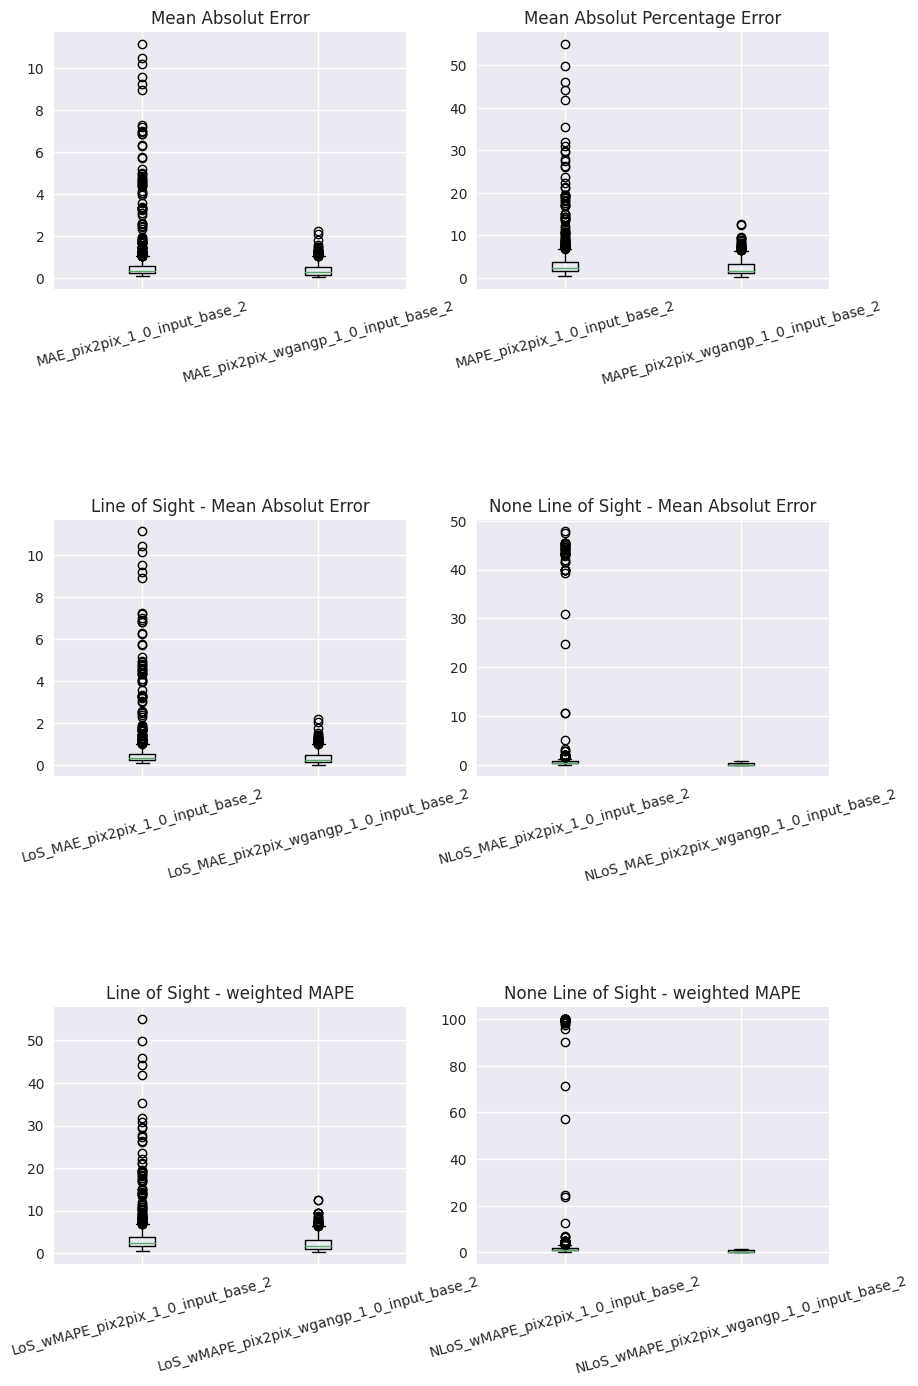

In [17]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 16))
# ax = ax.flatten()

# MEA
values = [merged_df[mae_model_1_name], merged_df[mae_model_2_name]]
names = [mae_model_1_name, mae_model_2_name]
ax[0][0].boxplot(x=values, notch=False)
ax[0][0].set_xticks([1, 2], names)
ax[0][0].set_xticklabels(names, rotation=15)
ax[0][0].set_title("Mean Absolut Error")

# MAPE
values = [merged_df[mape_model_1_name], merged_df[mape_model_2_name]]
names = [mape_model_1_name, mape_model_2_name]
ax[0][1].boxplot(x=values, notch=False)
ax[0][1].set_xticks([1, 2], names)
ax[0][1].set_xticklabels(names, rotation=15)
ax[0][1].set_title("Mean Absolut Percentage Error")

# LoS MEA
values = [merged_df[los_mae_model_1_name], merged_df[los_mae_model_2_name]]
names = [los_mae_model_1_name, los_mae_model_2_name]
ax[1][0].boxplot(x=values, notch=False)
ax[1][0].set_xticks([1, 2], names)
ax[1][0].set_xticklabels(names, rotation=15)
ax[1][0].set_title("Line of Sight - Mean Absolut Error")

# NLoS MEA
values = [merged_df[nlos_mae_model_1_name], merged_df[nlos_mae_model_2_name]]
names = [nlos_mae_model_1_name, nlos_mae_model_2_name]
ax[1][1].boxplot(x=values, notch=False)
ax[1][1].set_xticks([1, 2], names)
ax[1][1].set_xticklabels(names, rotation=15)
ax[1][1].set_title("None Line of Sight - Mean Absolut Error")

# LoS wMAPE
values = [merged_df[los_wmape_model_1_name], merged_df[los_wmape_model_2_name]]
names = [los_wmape_model_1_name, los_wmape_model_2_name]
ax[2][0].boxplot(x=values, notch=False)
ax[2][0].set_xticks([1, 2], names)
ax[2][0].set_xticklabels(names, rotation=15)
ax[2][0].set_title("Line of Sight - weighted MAPE")

# NLoS wMAPE
values = [merged_df[nlos_wmape_model_1_name], merged_df[nlos_wmape_model_2_name]]
names = [nlos_wmape_model_1_name, nlos_wmape_model_2_name]
ax[2][1].boxplot(x=values, notch=False)
ax[2][1].set_xticks([1, 2], names)
ax[2][1].set_xticklabels(names, rotation=15)
ax[2][1].set_title("None Line of Sight - weighted MAPE")

plt.subplots_adjust(hspace=0.9)

print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mae_model_2_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mape_model_2_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_mae_model_2_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_mae_model_2_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_wmape_model_2_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_wmape_model_2_name].mean():>0.2f}")

Example Image

In [18]:
def get_same_pred_real_samples(pred_path:str, real_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            # if len(cur_id) > 1:
            #     raise ValueError("Too many ids found!")
            cur_id = cur_id[0]
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                # if len(cur_id) > 1:
                #     raise ValueError(f"Too many ids found in {cur_image}!")
                if len(cur_id) <= 0:
                    continue
                    # raise ValueError(f"No id found in {cur_image}!")
                cur_id = cur_id[0]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            # if len(cur_id) > 1:
            #     raise ValueError(f"Too many ids found in {cur_image}!")
            if len(cur_id) <= 0:
                continue
                # raise ValueError(f"No id found in {cur_image}!")
            cur_id = cur_id[0]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    result_samples += [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    return result_samples, ids

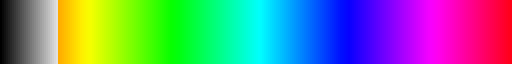

In [19]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if r > 0.99 and g < (170/255):
            gray_value = cur_idx*8 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

# for i in range(256):
#     print([int(cur_color*255) for cur_color in get_cmap('hsv')(i)])

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [39]:
def plot(ax, path, title="", invert=True, sub_image=None, cmap="unique_hsv", scale=False, logscale=False, plot=True):
    img = np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

    if sub_image:
        img_2 = np.array(cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE))
        # img = cv2.subtract(img, img_2)
        img = img - img_2
        img[img < 0] = img[img < 0] * -1
        # img = np.abs(img - img_2)
    
    # # scaling
    # if scale:
    #     mask = (img > 0) & (img < 160)
    #     img[mask] = np.clip(img[mask] + 40, 0, 255) # cv2.add(img[mask], 30)

    # invert
    if invert:
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # # Apply logarithmic scaling to enhance contrast in dim regions
    # if logscale:
    #     img = np.log1p(img)
    #     # img /= img.max()  # normalize to [0,1]

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

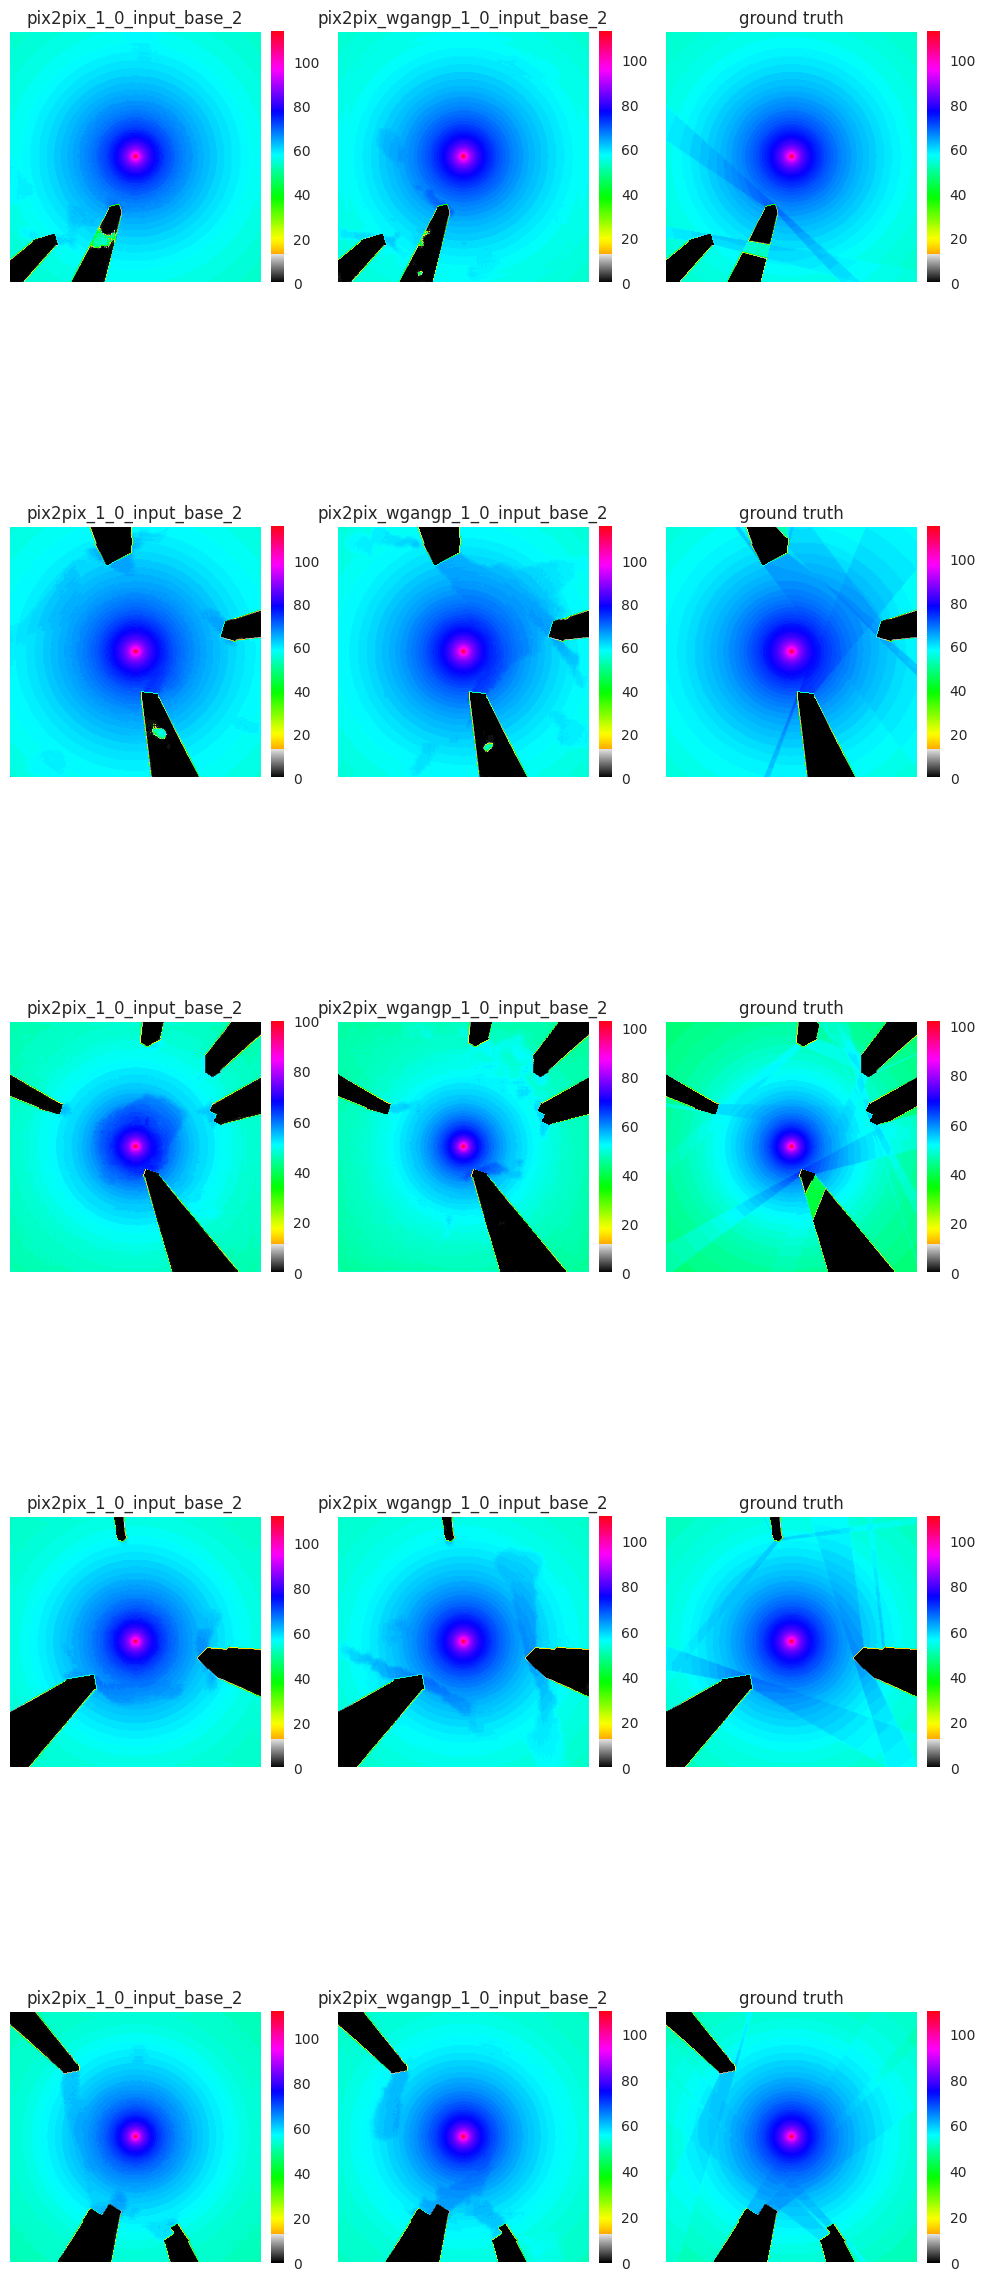

In [40]:
n_samples = 5

example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    n_samples)
example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    n_samples, ids)

pred_model_1 = example_images_model_1[:n_samples]
pred_model_2 = example_images_model_2[:n_samples]
real = example_images_model_2[n_samples:] 

fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(3*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", invert=True)

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", invert=True)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", invert=True)

plt.subplots_adjust(hspace=0.5)

plt.show();

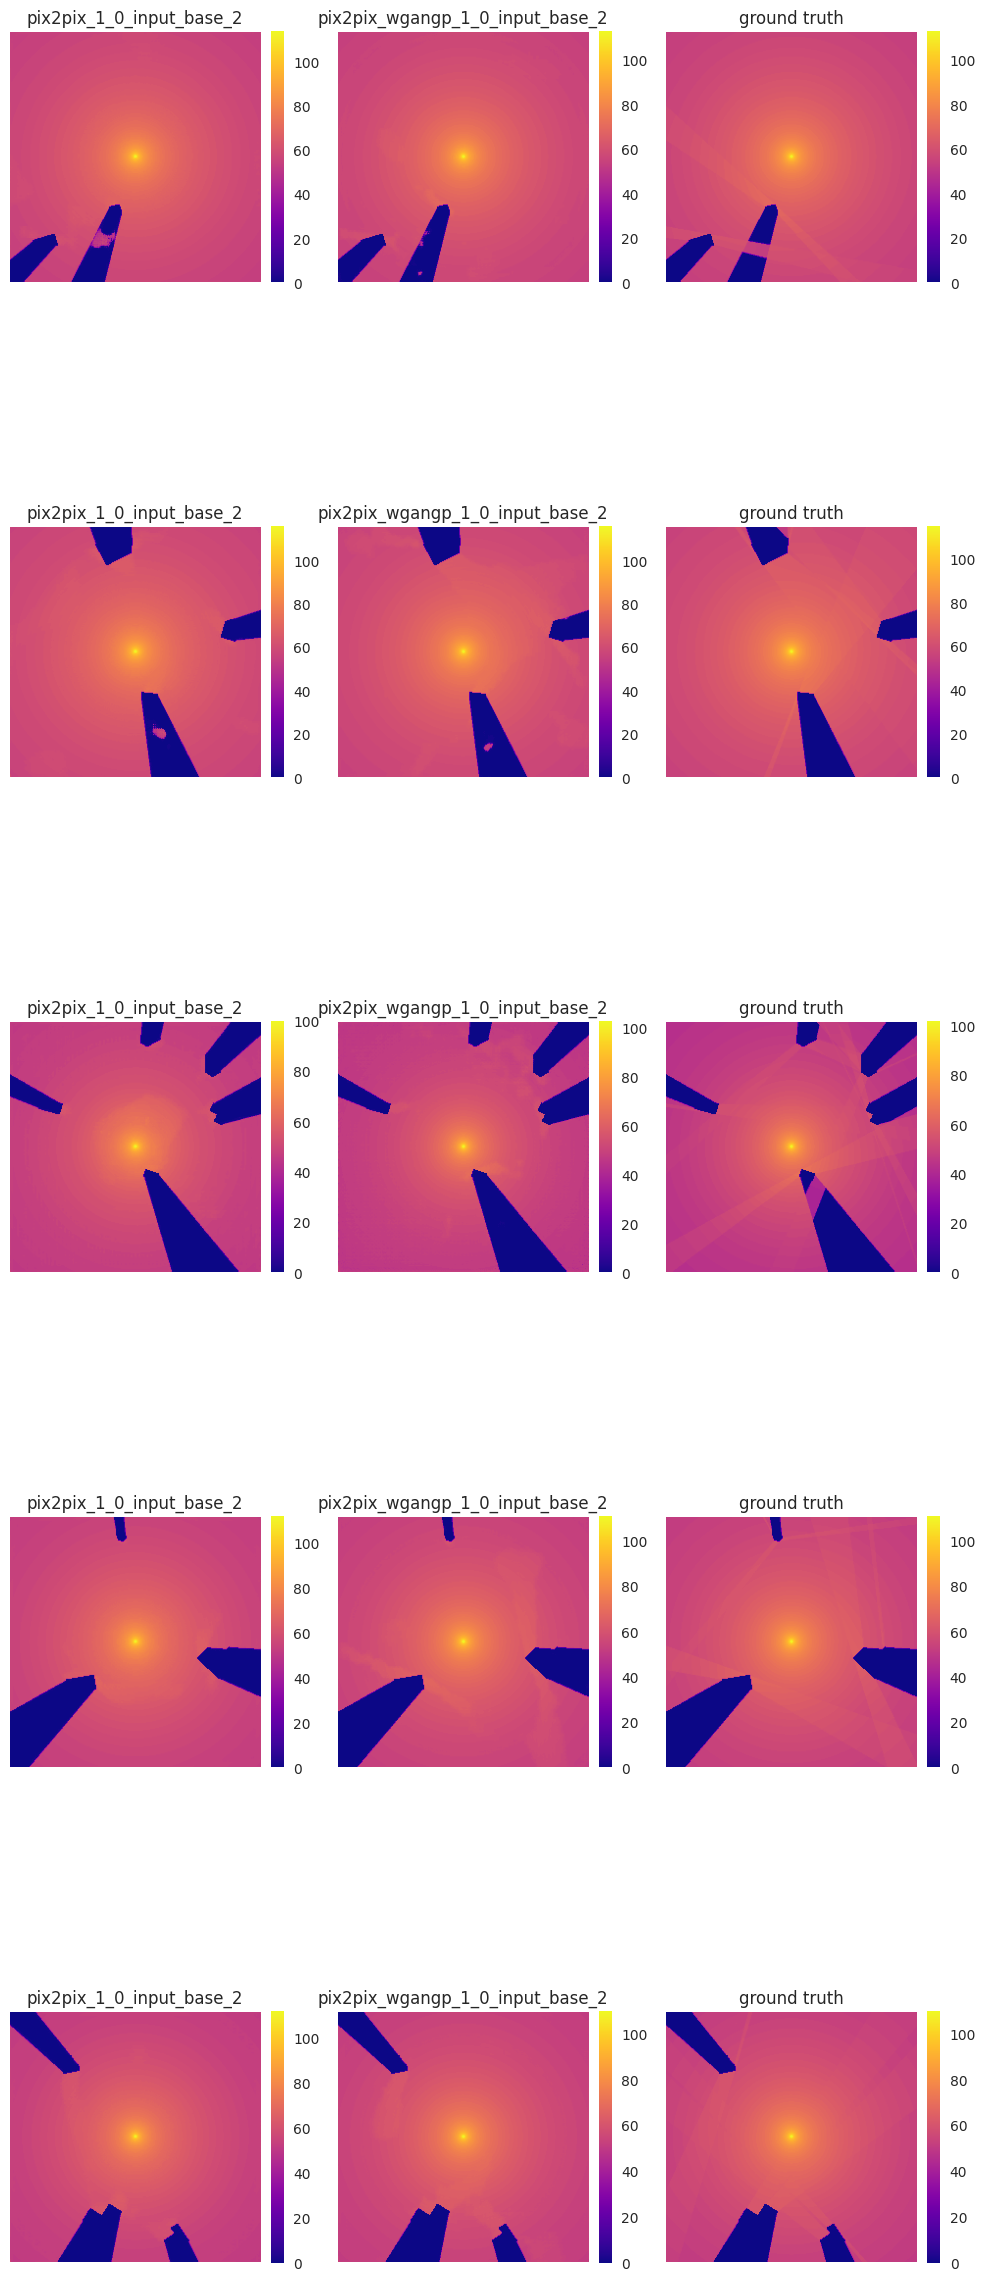

In [41]:
fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(3*4, n_samples*6))

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", invert=True, cmap="plasma")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", invert=True, cmap="plasma")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", invert=True, cmap="plasma")

plt.subplots_adjust(hspace=0.5)

plt.show();

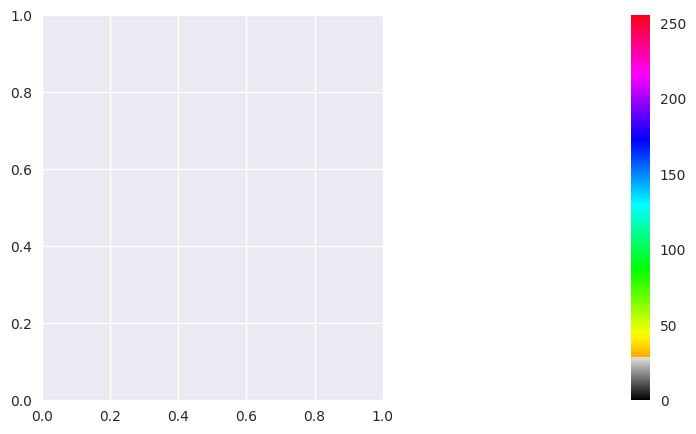

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="unique_hsv", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

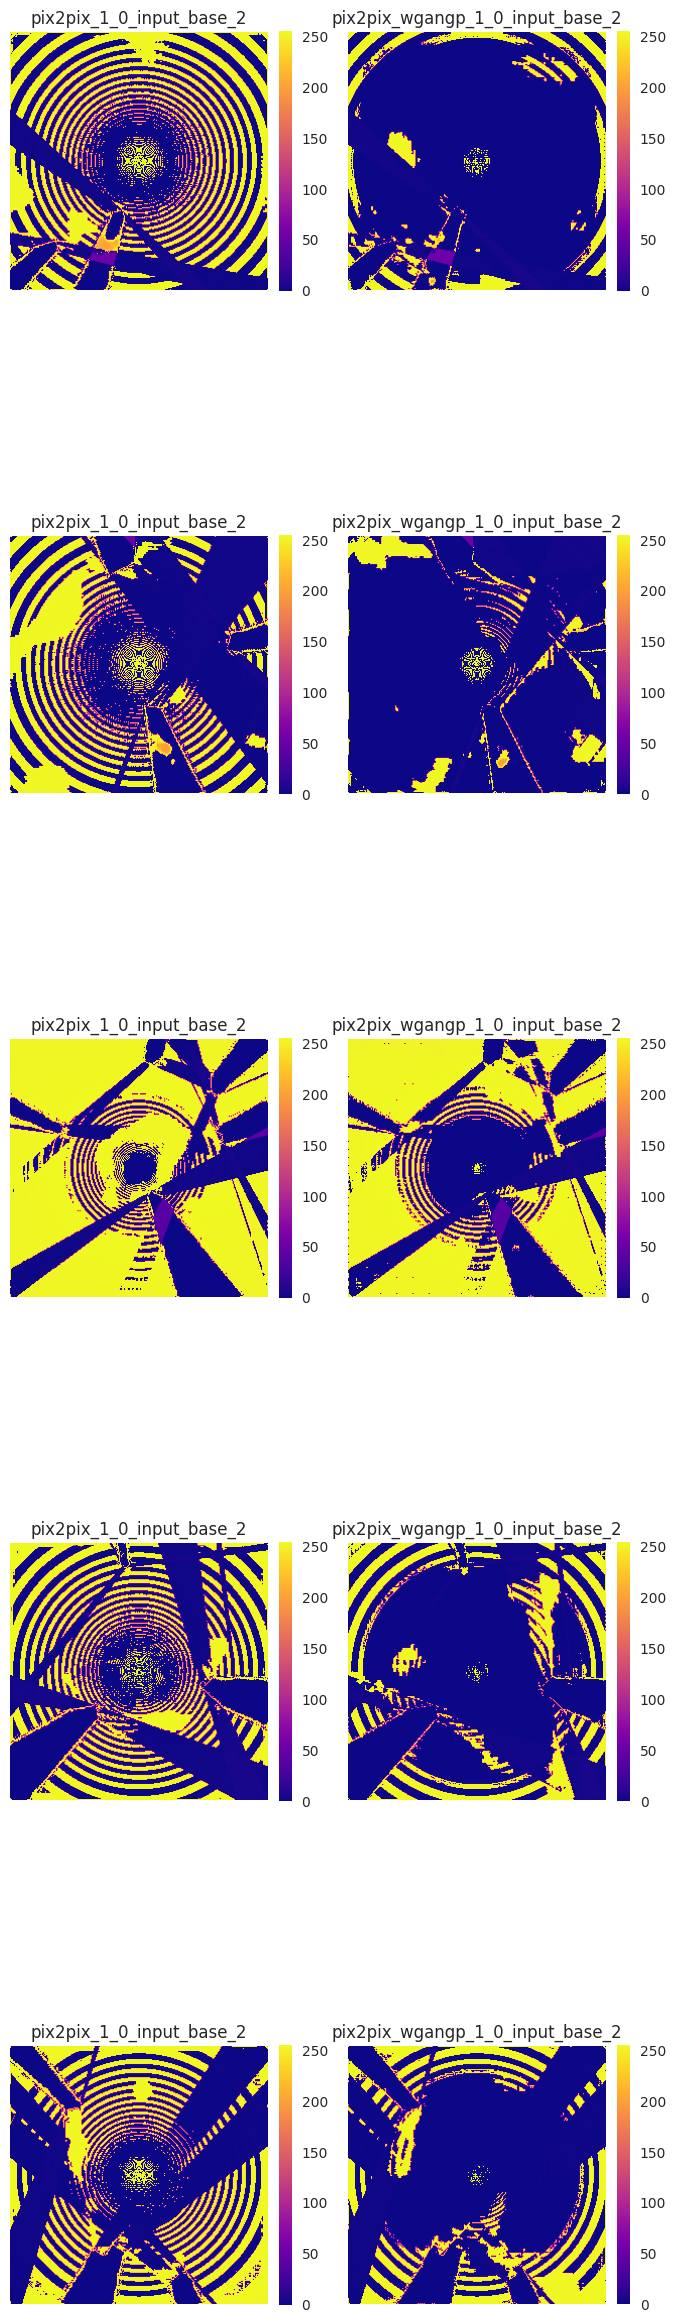

In [42]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", sub_image=real[idx], invert=False, scale=False, cmap="plasma")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", sub_image=real[idx], invert=False, scale=False, cmap="plasma")

plt.subplots_adjust(hspace=0.7)
plt.show();

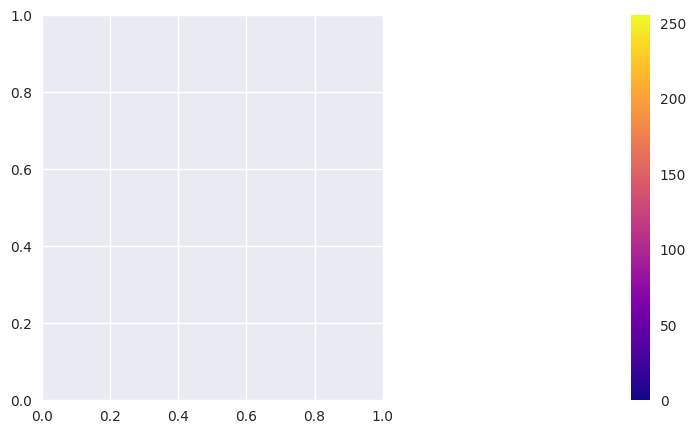

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

Inspect some single images in more detail here:

In [26]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

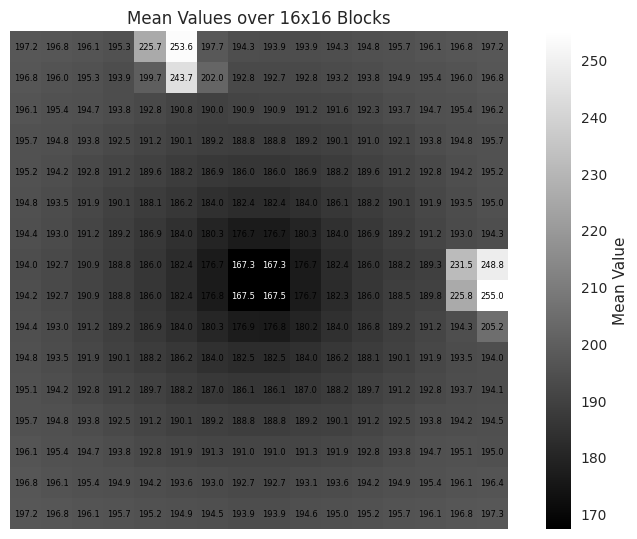

In [27]:
img_path = pred_model_1[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

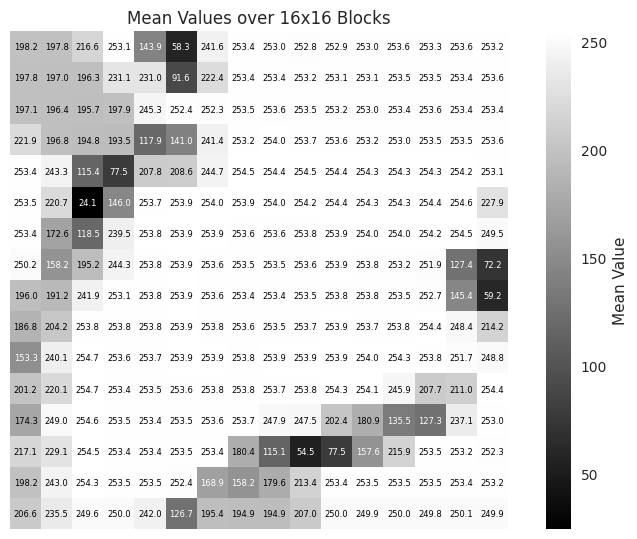

In [28]:
img = plot(None, path=pred_model_1[0], title=f"{model_1}", sub_image=real[idx], invert=False, scale=True, plot=False)
plot_image_with_values(img, block_size=16)

### Old Code /Visualization

Examples from pix2pix_1_0_input_base_2


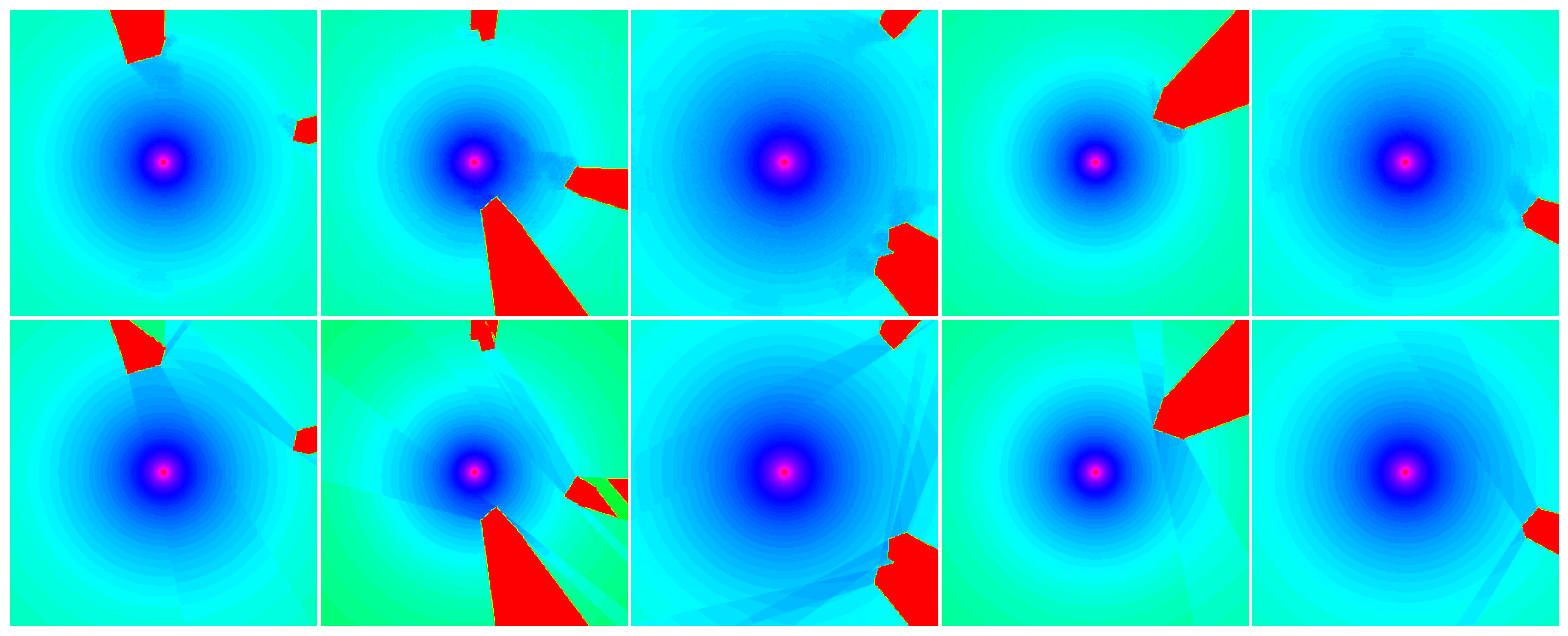

Examples from pix2pix_wgangp_1_0_input_base_2


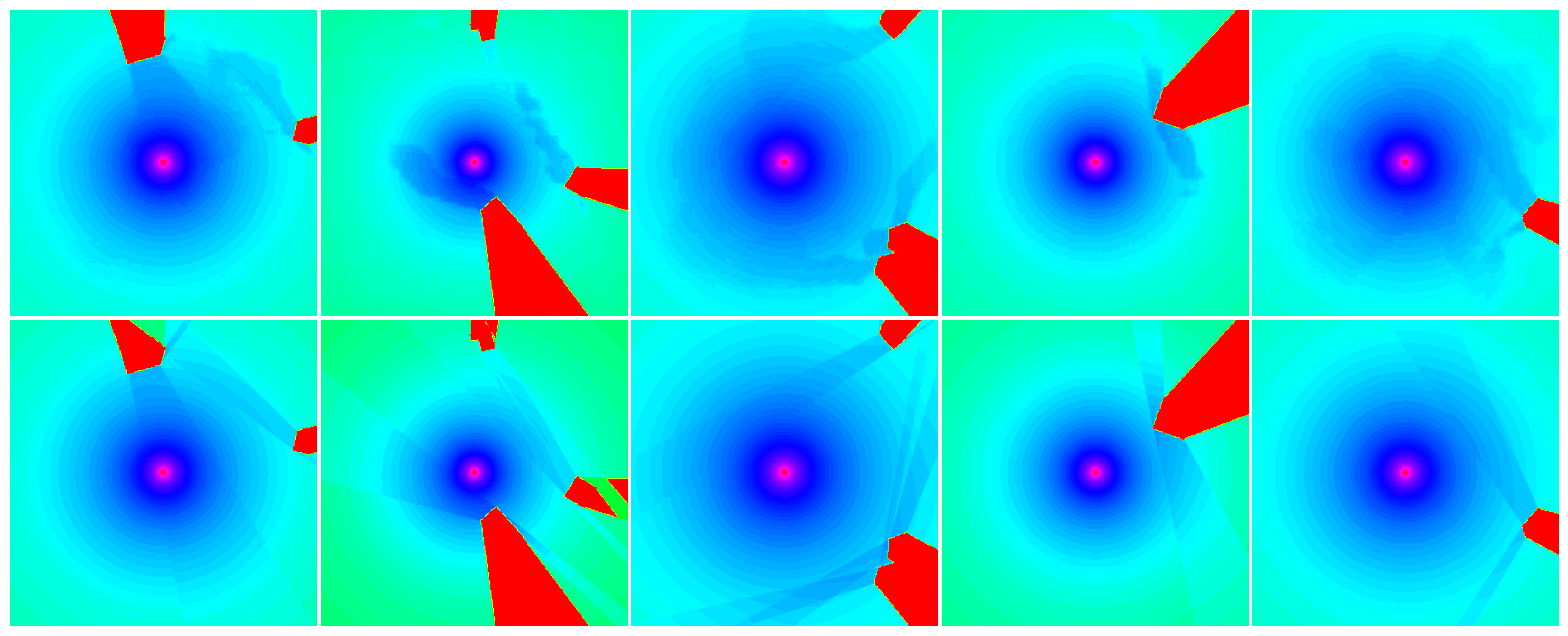

In [29]:
example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    5)
print(f"Examples from {model_1}")
show_images(image_paths=example_images_model_1, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    5, ids)
print(f"Examples from {model_2}")
show_images(image_paths=example_images_model_2, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Examples from pix2pix_1_0_input_base_2


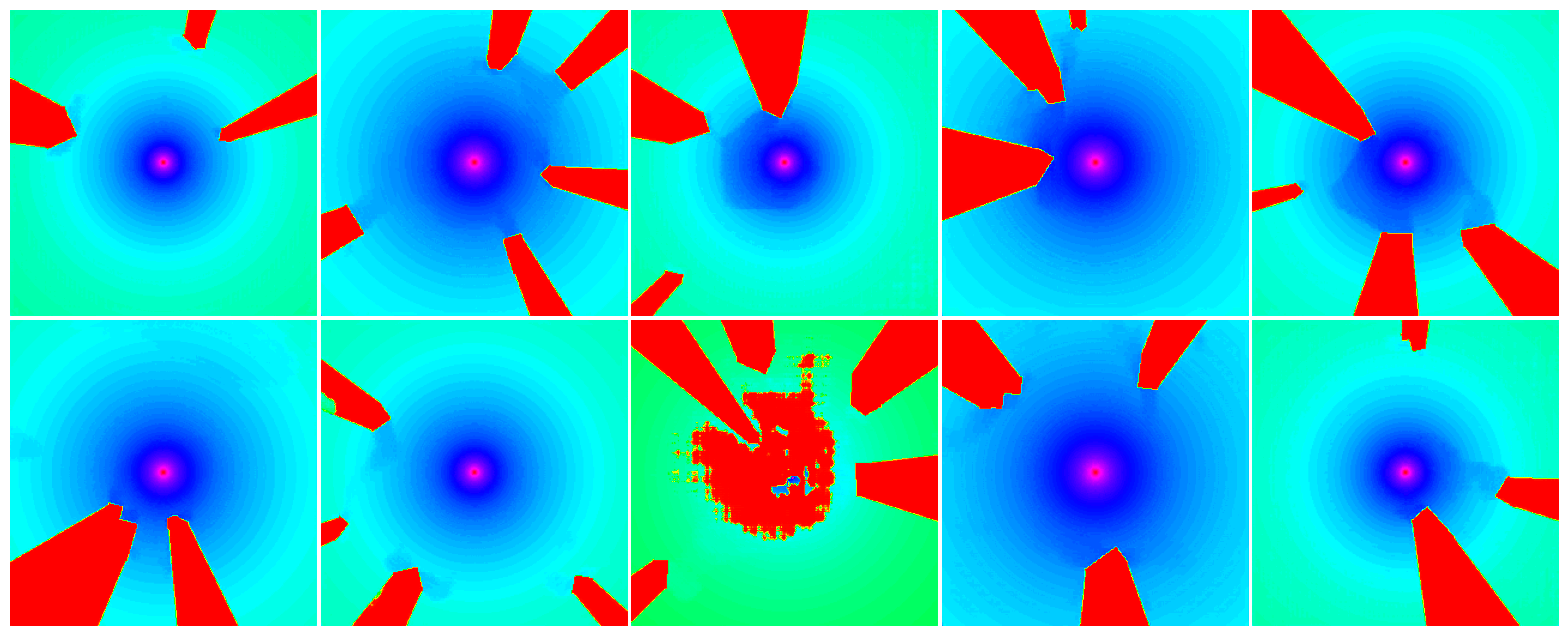

Examples from pix2pix_wgangp_1_0_input_base_2


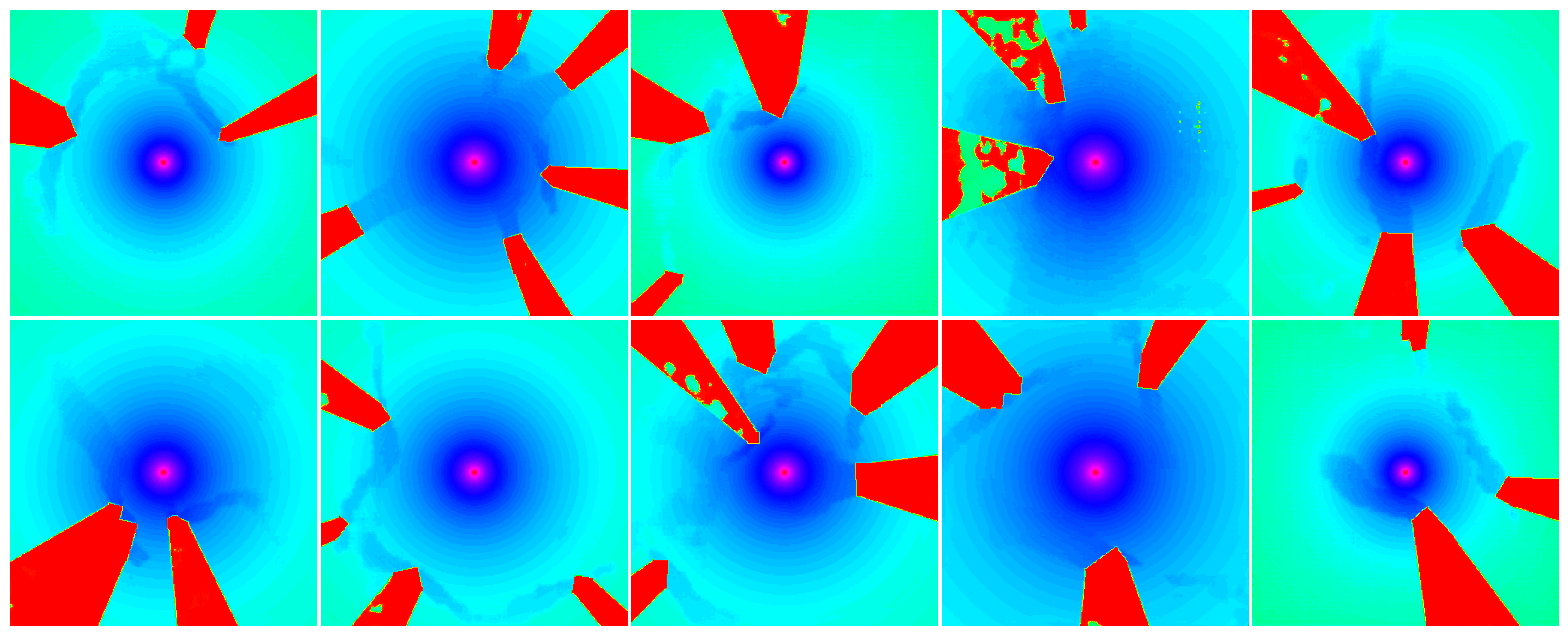

In [30]:
path = f"../../data/eval/{model_1}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_1}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False)

path = f"../../data/eval/{model_2}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_2}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Amont of unique values: 95


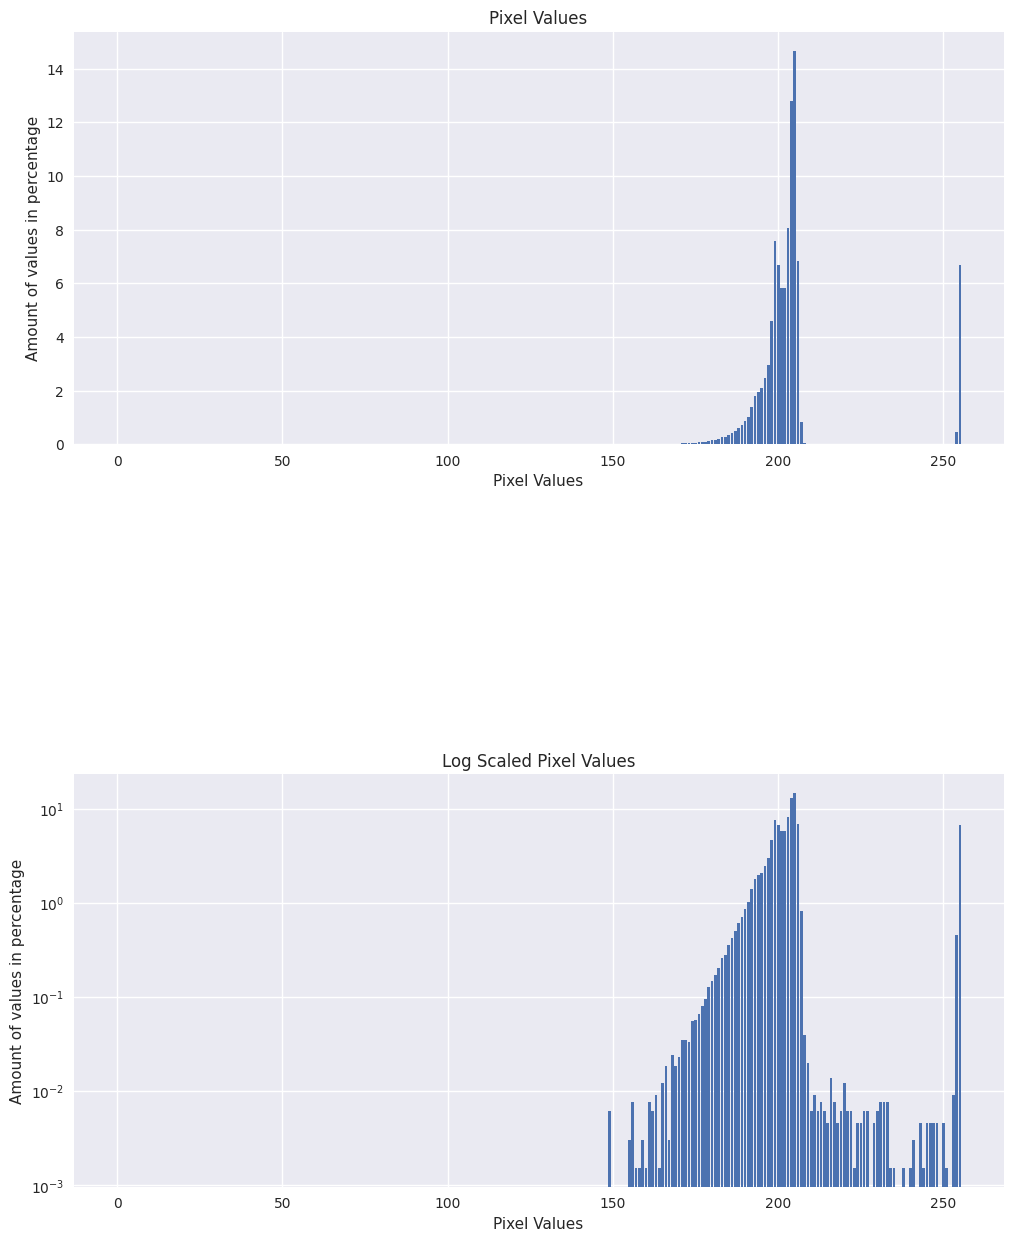

In [31]:
img = cv2.imread(example_images[0], cv2.IMREAD_GRAYSCALE)
unique_values = np.unique(img)
print("Amont of unique values:", len(unique_values))

counts = np.bincount(img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

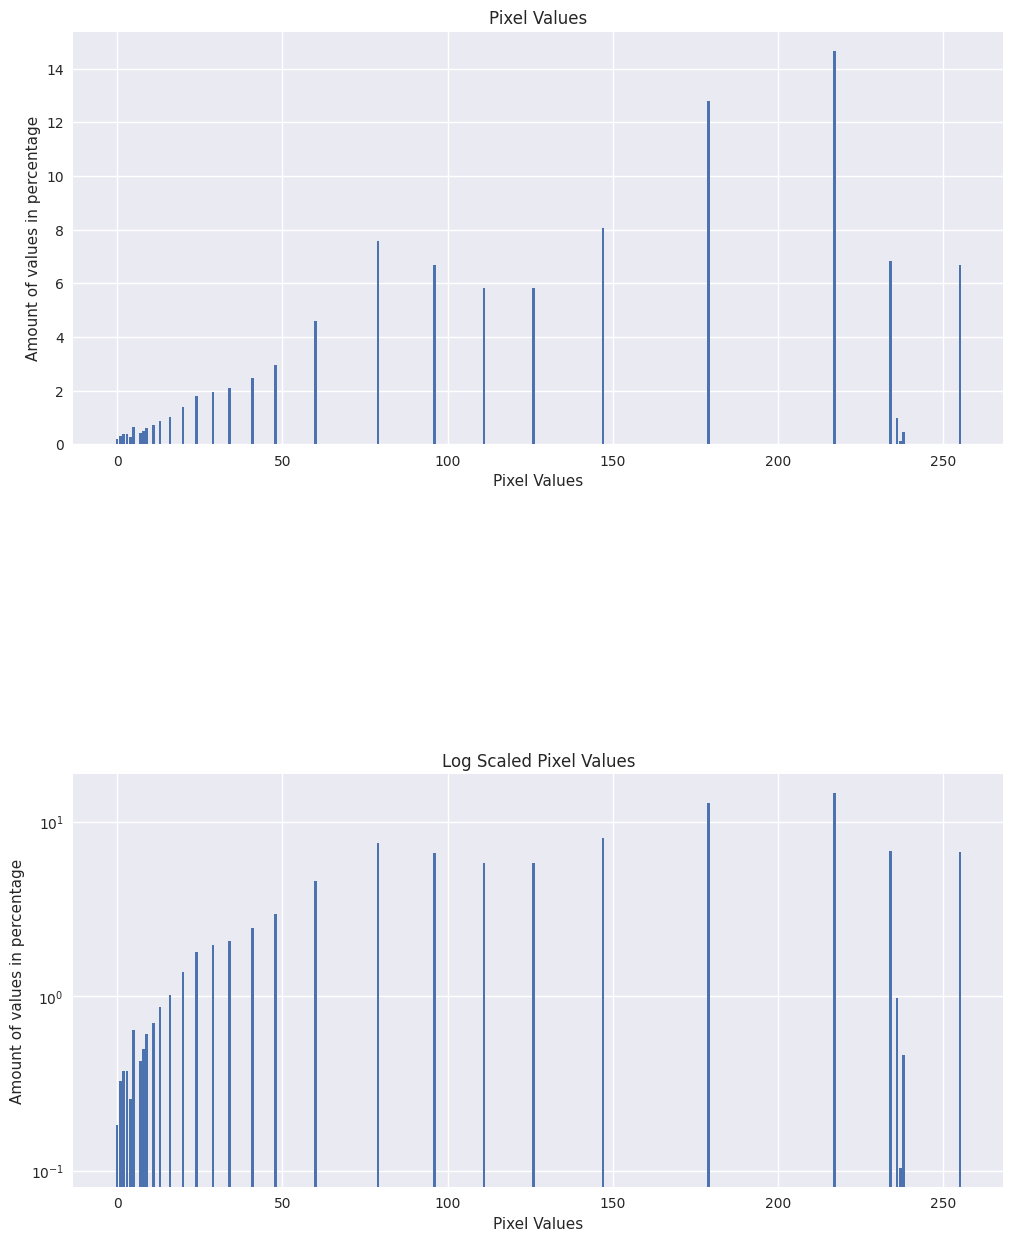

In [32]:
# Apply histogram equalization (clipping values to the range 100-255)
equalized_img = cv2.equalizeHist(img)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

# # Plot the histogram
# plt.hist(equalized_img.flatten(), bins=256, range=(100, 255), density=True)
# plt.xlabel("Pixel Values")
# plt.ylabel("Frequency")
# plt.show()

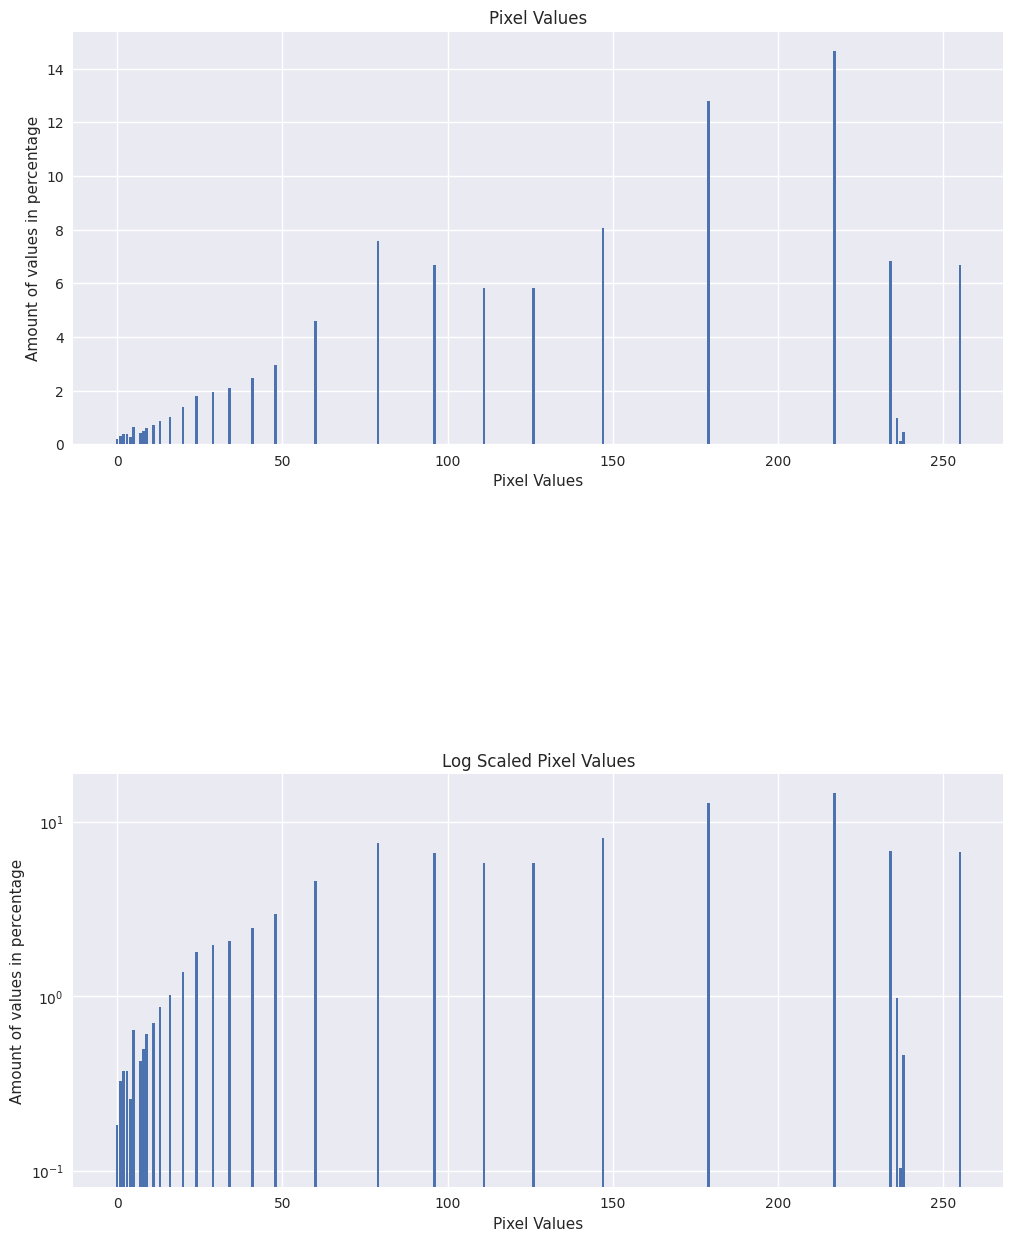

In [33]:
normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
normalized_img = normalized_img * (255)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

### Quantizitation Error Check


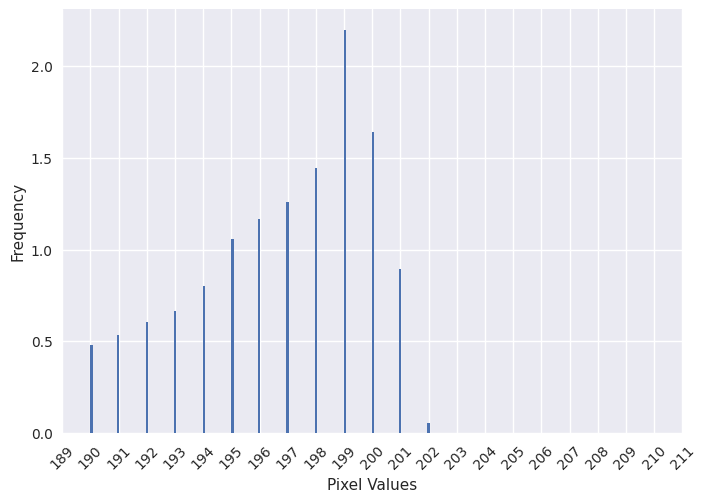

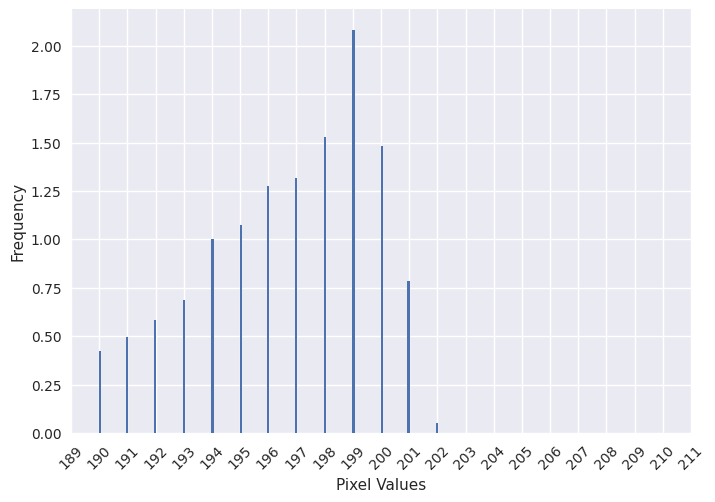

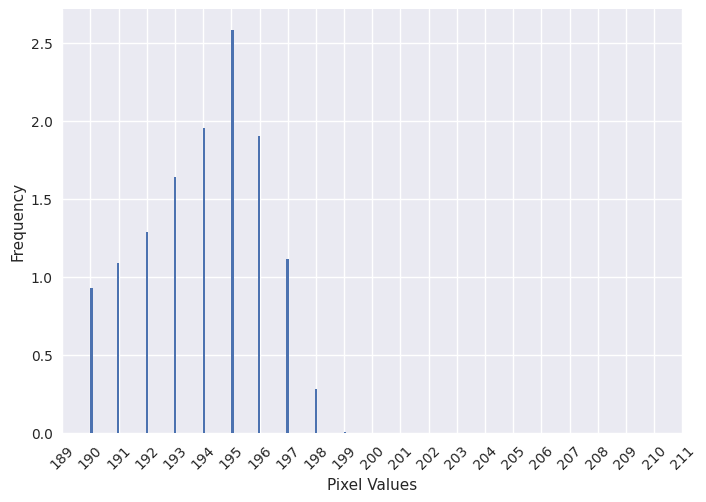

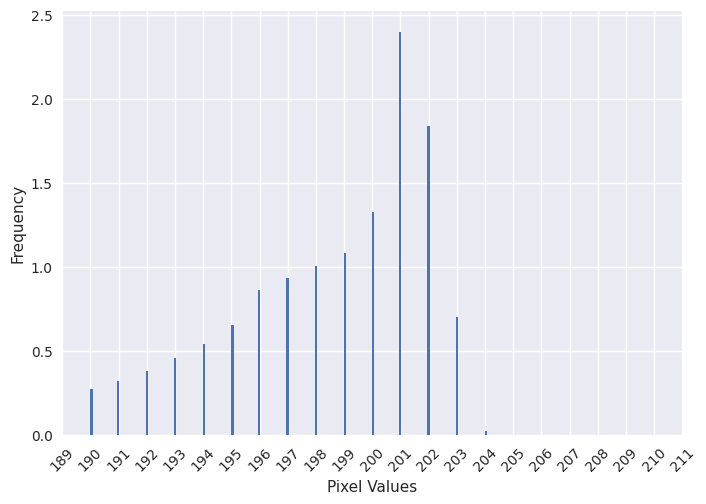

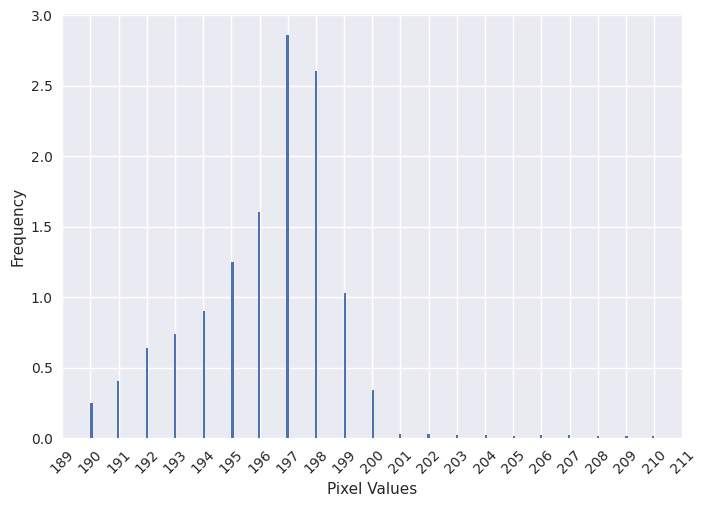

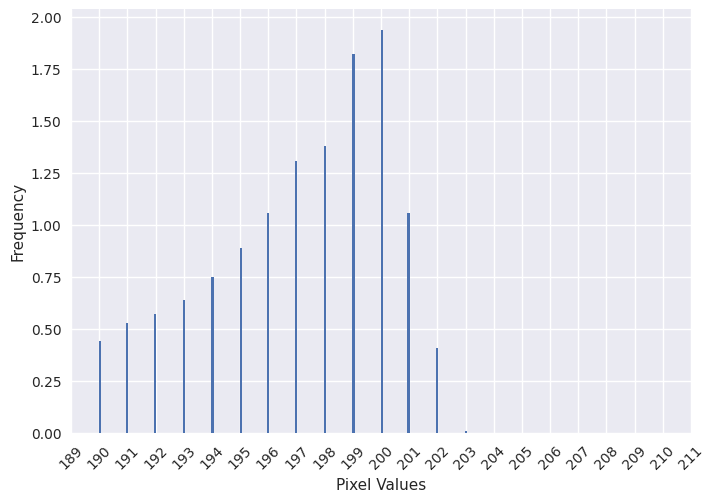

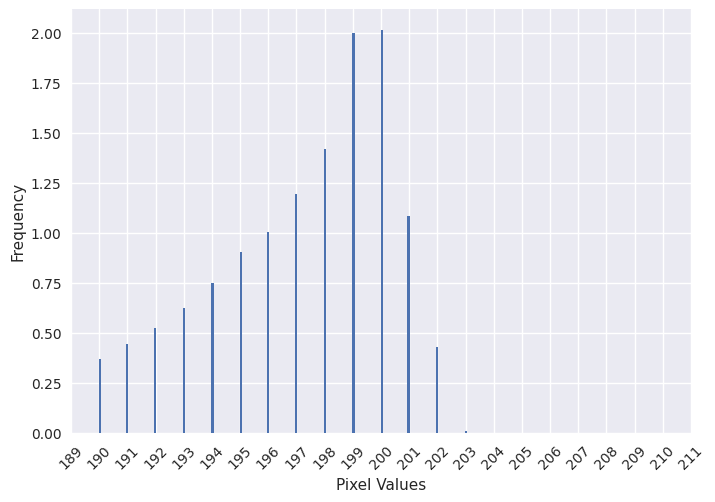

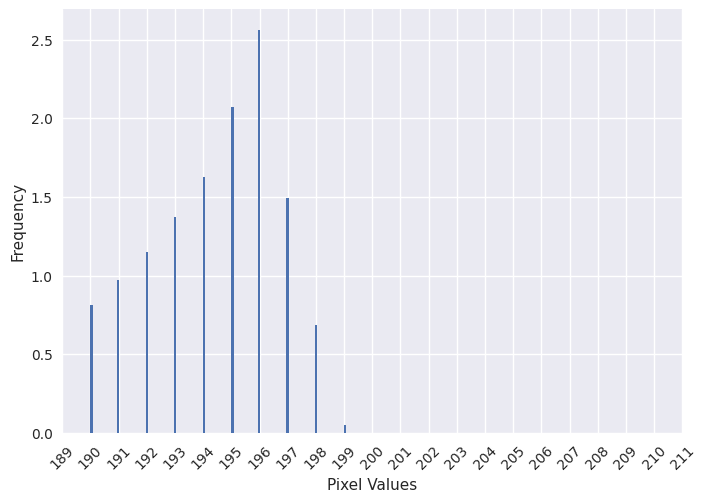

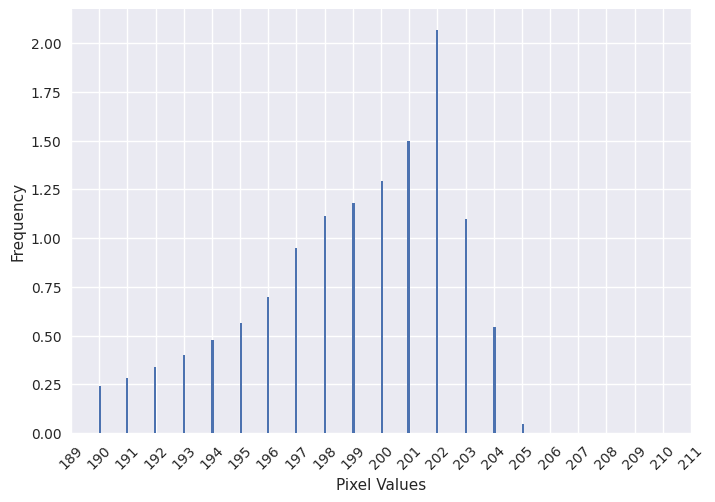

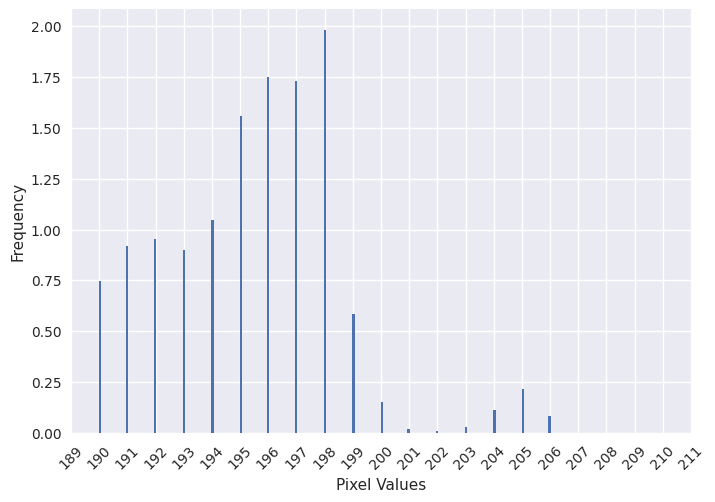

In [34]:
from matplotlib.ticker import MultipleLocator

example_images_model_2, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                         f"../../data/eval/{model_1}/real",
                                                         n_samples)

# Plot the histogram
for cur_image in example_images_model_2:
    img = np.array(cv2.imread(cur_image, cv2.IMREAD_GRAYSCALE))
    plt.hist(img.flatten(), bins=256, range=(190, 210), density=True)
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")

    # Set every x-tick (e.g., every 1 value from 190 to 255)
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.xticks(rotation=45)

    plt.show()

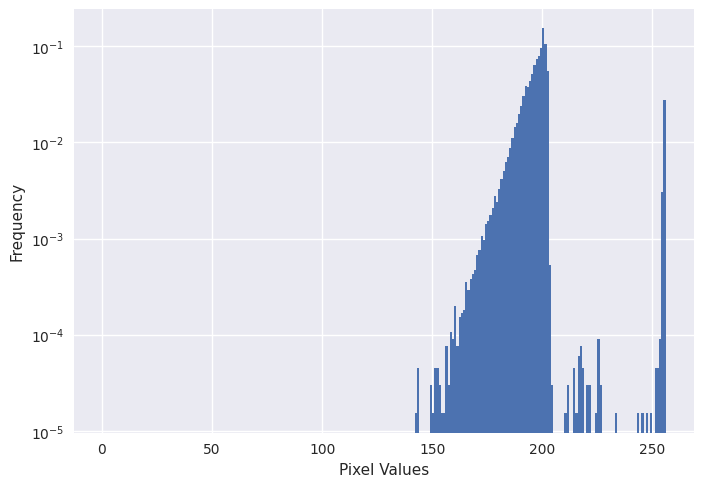

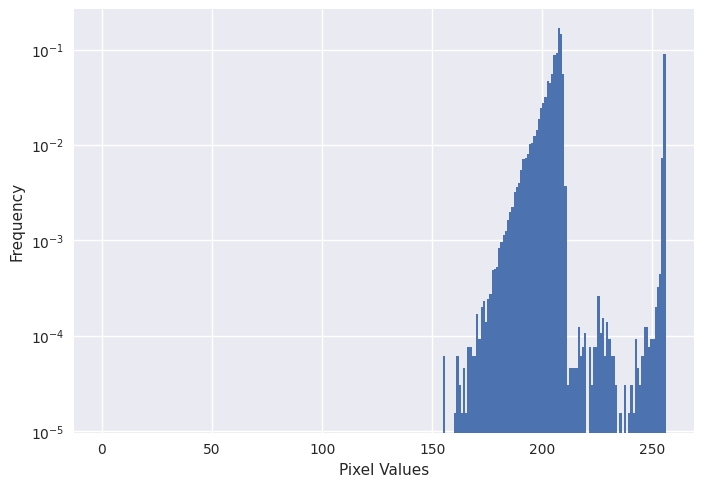

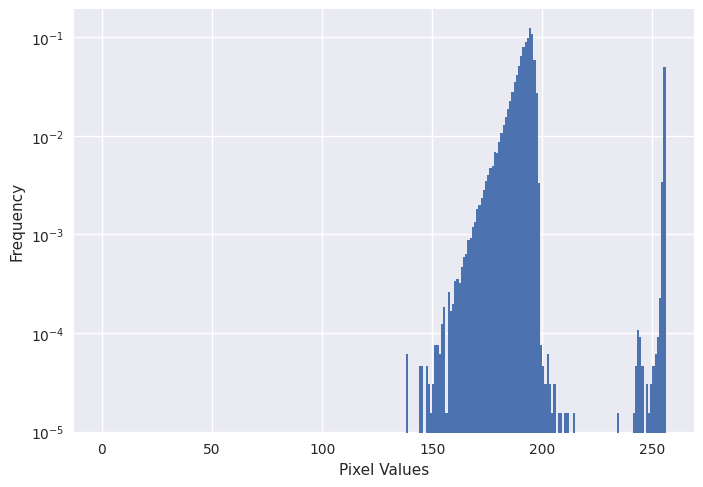

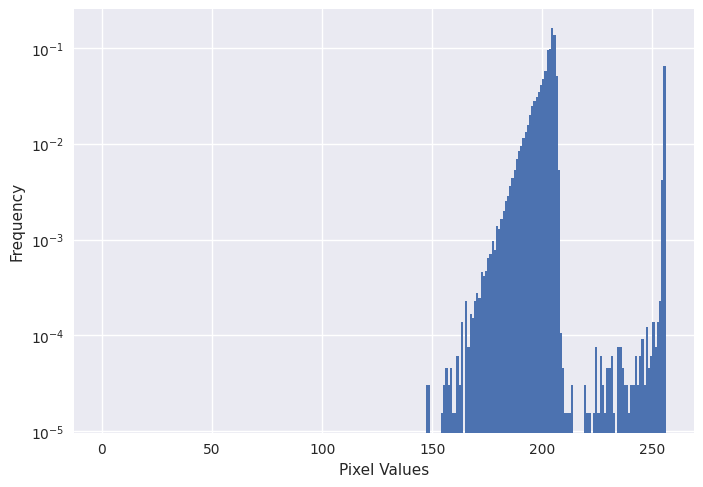

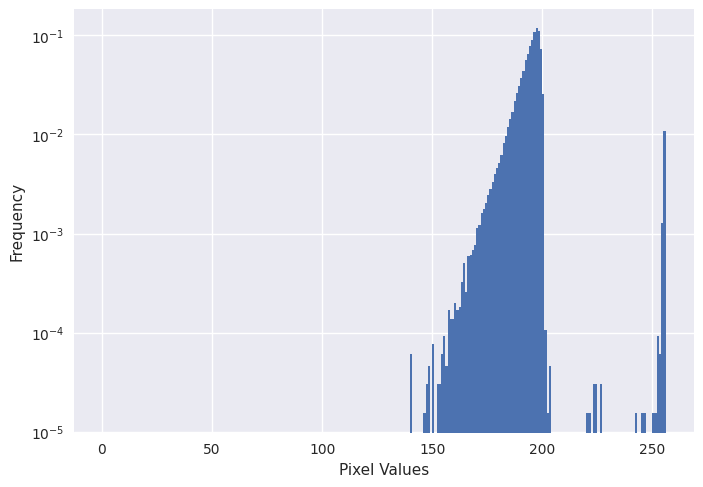

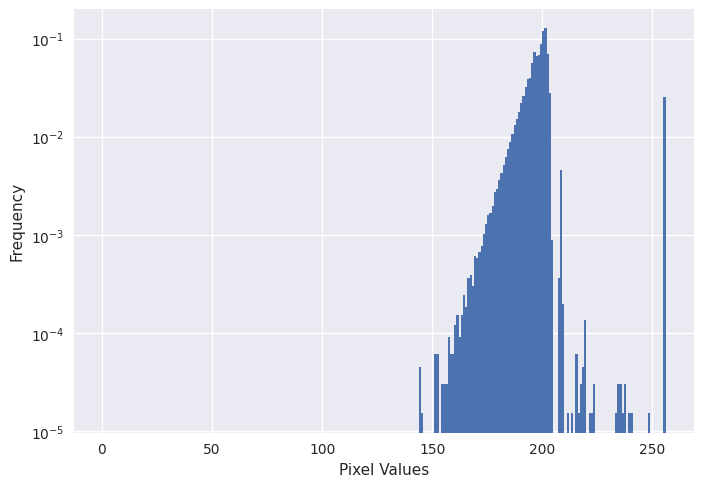

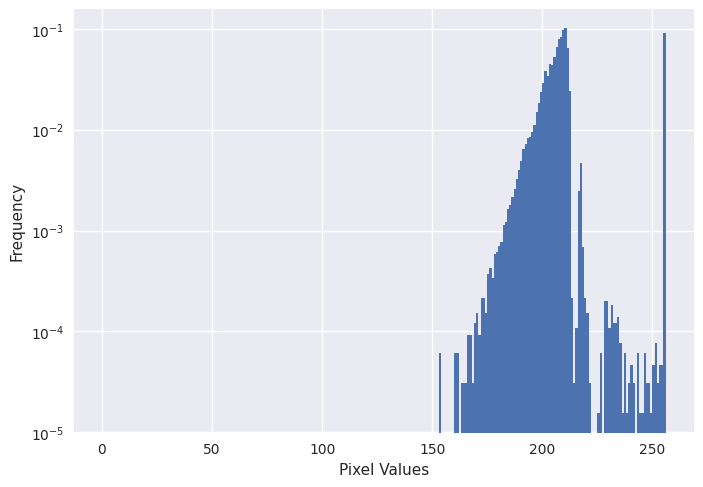

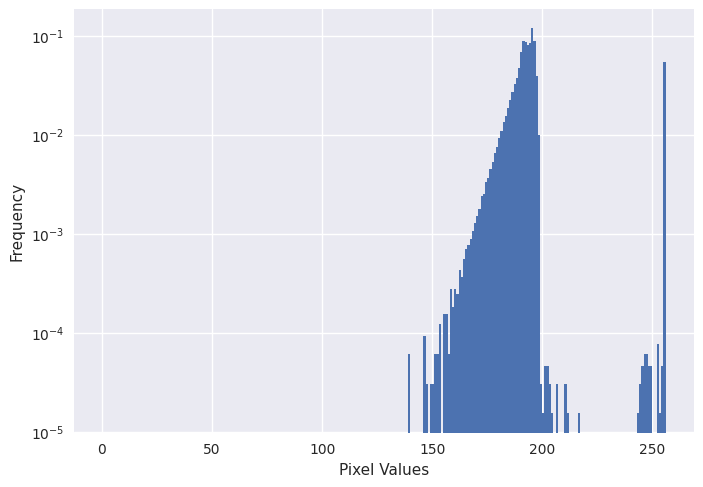

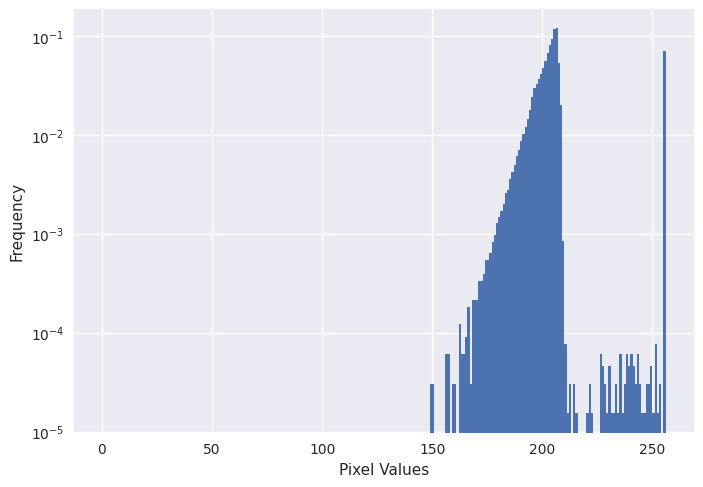

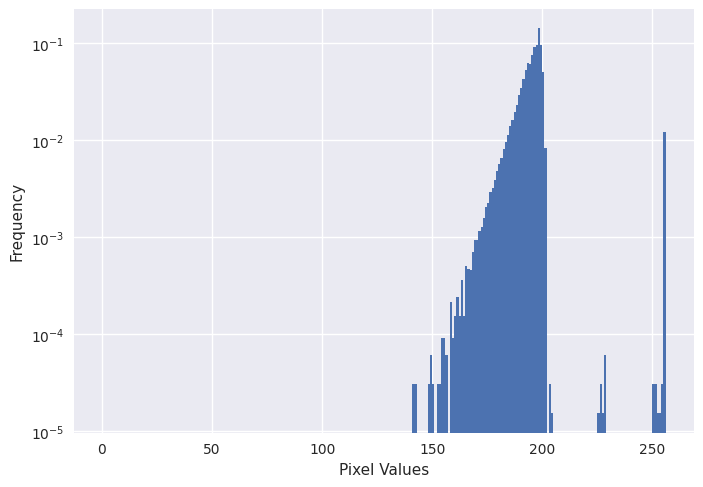

In [35]:
for cur_image in example_images_model_1:
    img = np.array(cv2.imread(cur_image, cv2.IMREAD_GRAYSCALE))
    plt.hist(img.flatten(), bins=256, range=(0, 256), density=True)
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.show()

In [36]:
processed_example_images_model_2 = []
for cur_image in example_images_model_2:
    processed_example_images_model_2 += [plot(None, path=cur_path, title=f"ground truth", plot=False)]

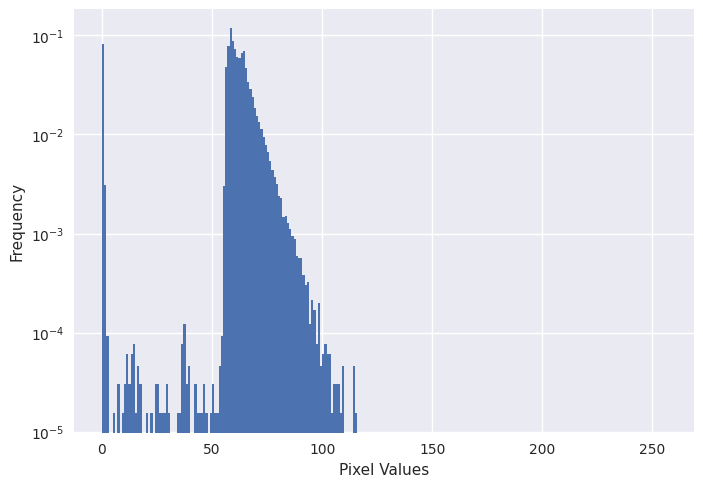

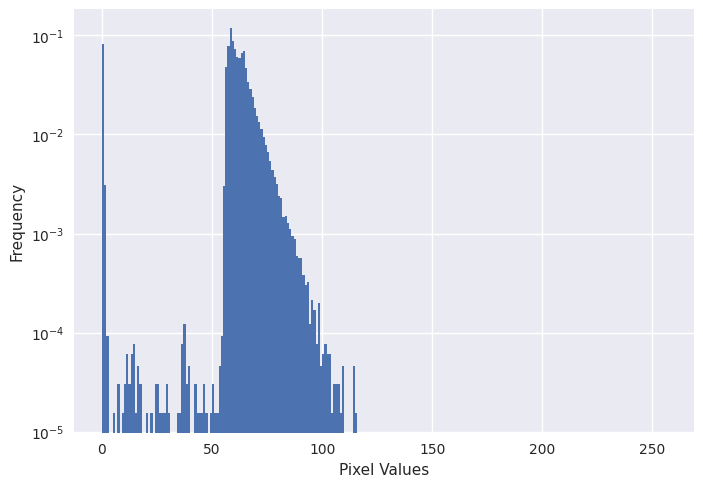

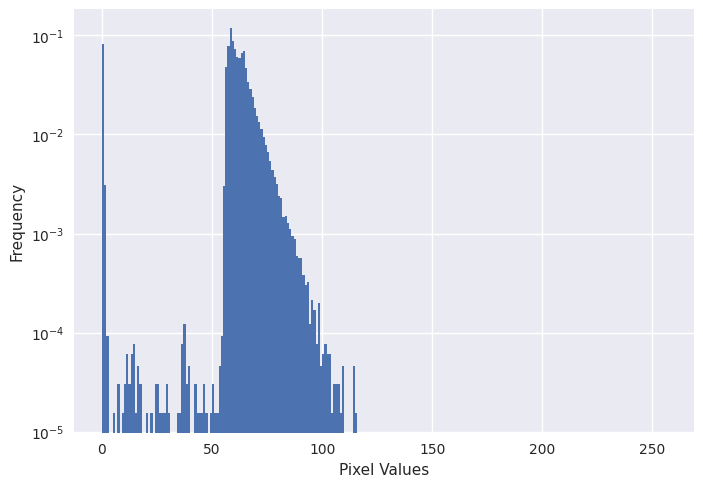

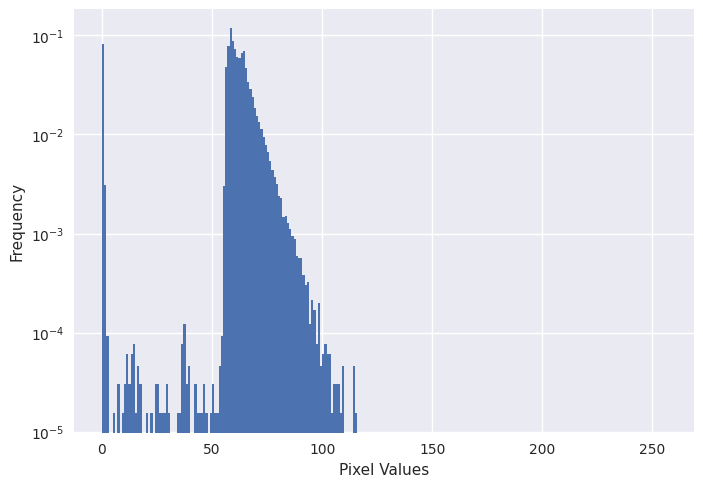

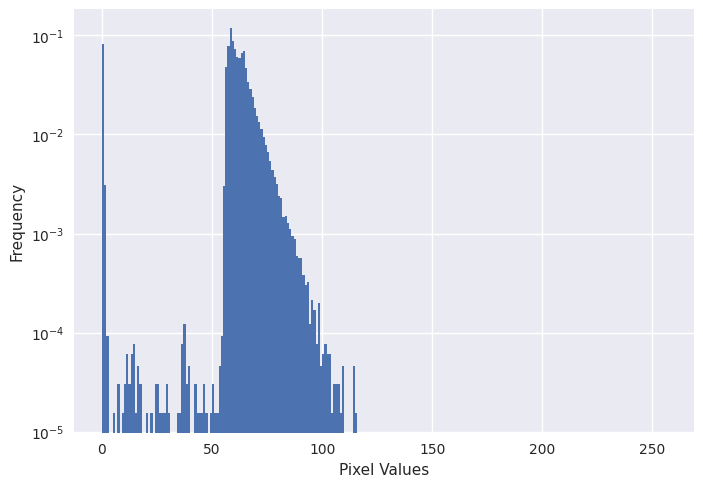

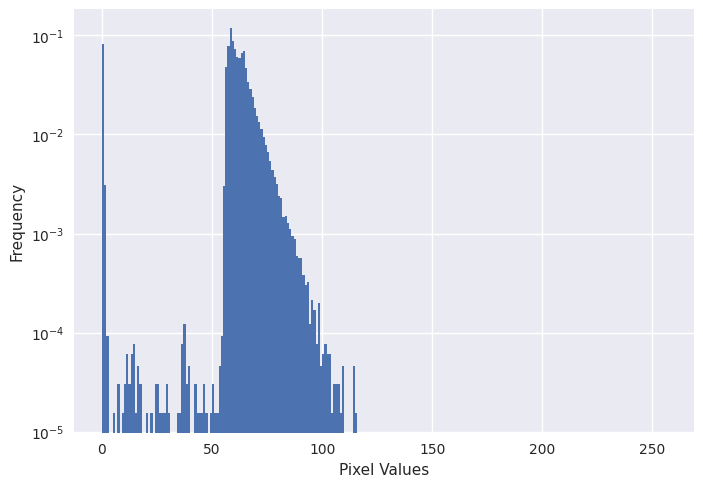

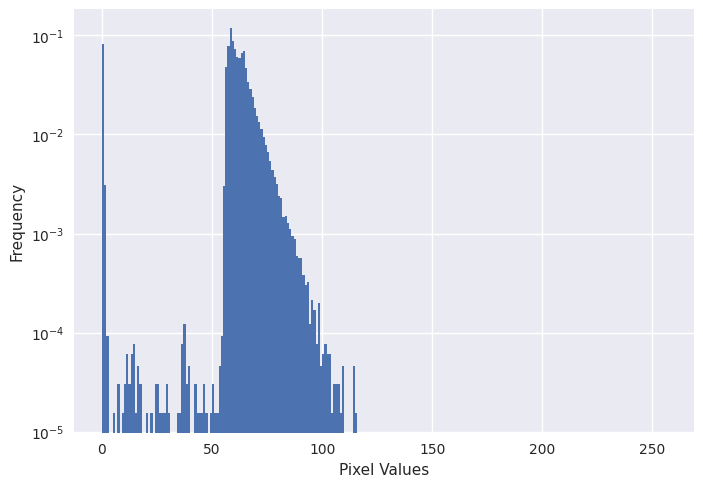

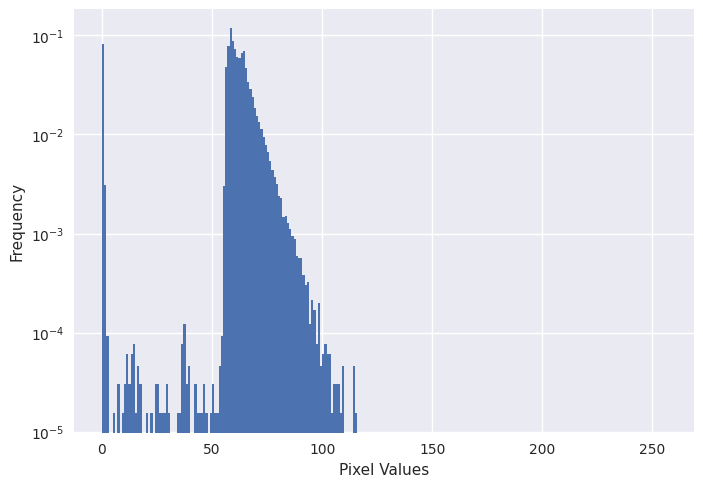

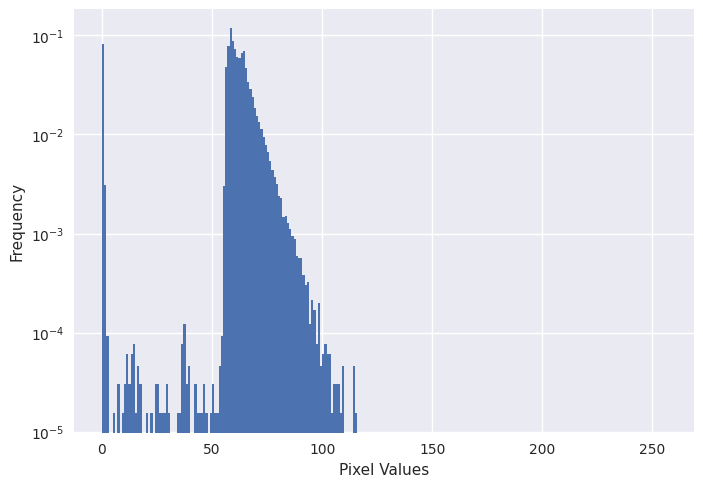

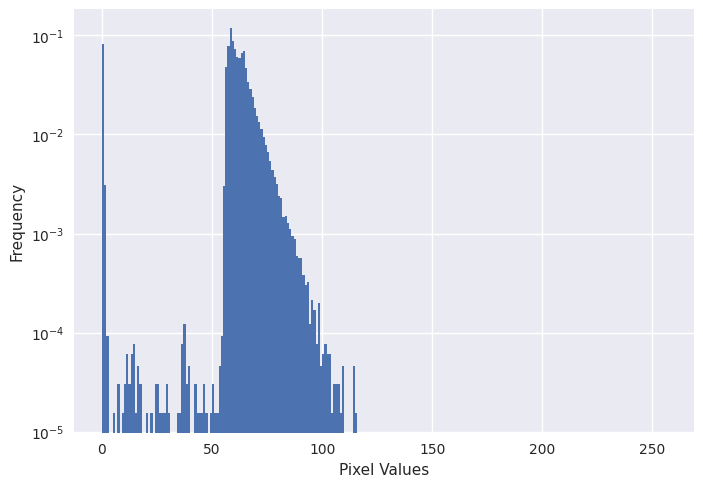

In [37]:
for cur_image in processed_example_images_model_2:
    img = cur_image
    plt.hist(img.flatten(), bins=256, range=(0, 256), density=True)
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.show()